In [2]:
#precip analysis
import glob
import xarray as xr
import os
import numpy as np
import warnings
import sys
import pickle
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/disk/p/jkcm/Code')
from Lagrangian_CSET.CSET_data_classes import CSET_Flight
from Lagrangian_CSET import utils
from Lagrangian_CSET import met_utils as mu
from Lagrangian_CSET.LoopTimer import LoopTimer
%load_ext autoreload
%autoreload 2

In [158]:
def get_precip_from_leg(flight, start_time, end_time):
    precip_data_location = r'/home/disk/eos4/jkcm/Data/CSET/precip_retrievals'
    precip_file = glob.glob(os.path.join(precip_data_location,
                                  'RF{:02}_*.cdf'.format(flight)))
    if len(precip_file) == 0:
        return([np.nan])
    with xr.open_dataset(precip_file[0]) as data:
        data['time'].values = data.time.values.astype('datetime64')
        precip_data = data.sel(time=slice(start_time, end_time))
        prec = precip_data['lwf']
        col_max = prec.max(dim='height', skipna=True)   
    return col_max.values*3.6*24  # in mm/day, from g/m2/s originally
    #open the right precip file
    #chop out the right segment
    #get the colmax precips
    #return that whole array

In [159]:
x = utils.read_CSET_Lookup_Table(rf_num='all', sequences='all', legs=['b'], 
                                 variables=['Date', 'ST', 'ET', 'uhsas_conc1_M', 'Lat_S', 'Lat_E', 'Lon_S', 'Lon_E'])
start_dates = [utils.CSET_date_from_table(x['Date']['values'][i], x['ST']['values'][i])
               for i in range(len(x['Date']['values']))]
end_dates = [utils.CSET_date_from_table(x['Date']['values'][i], x['ET']['values'][i])
             for i in range(len(x['Date']['values']))]
lats = (x['Lat_S']['values'] + x['Lat_E']['values'])/2
lons = (x['Lon_S']['values'] + x['Lon_E']['values'])/2
times = [utils.CSET_date_from_table(x['Date']['values'][i], (x['ST']['values'][i]+x['ET']['values'][i])/2)
               for i in range(len(x['Date']['values']))]
Nds = x['uhsas_conc1_M']['values']
Nds[Nds=='-'] = np.nan
Nds = Nds.astype(float)
locs = np.array([lats, lons, times]).T
flights = x['rf']
all_precips = []
mean_precips = []
for (start_time, end_time, rf) in zip(start_dates, end_dates, flights):
    precips = get_precip_from_leg(rf, start_time, end_time)
    all_precips.append(precips)
    mean_precips.append(np.nanmean(precips))
    
    
locs = np.array([lats, lons, times, all_precips]).T

In [160]:
data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
with open(os.path.join(data_loc, 'nep_scenes.pickle'), 'rb') as f:
    nep_scenes = pickle.load(f)

lats_nep = nep_scenes['lats_nep']
lons_nep = nep_scenes['lons_nep']
int_local_days_nep = nep_scenes['int_local_days_nep']
scenes_nep = nep_scenes['scenes_nep']

In [161]:
min_dists = []
best_scenes = []
failed_locs = []
precip_by_scene = {-1: [],
                 0: [],
                 1: [],
                 2: [],
                 3: [],
                 4: []}
for i, loc in enumerate(locs):
    lat, lon = loc[0], loc[1]
    dec_day = loc[2].timetuple().tm_yday + (loc[2].hour + loc[2].minute/60)/24
    local_day = dec_day + lon/360
    matching_days = int_local_days_nep == int(local_day)
    dists = [np.sqrt((lat-lat2)**2 + (lon-lon2)**2) for lat2, lon2 in zip(lats_nep[matching_days], lons_nep[matching_days])]
    if dists:
        best_i = np.argmin(dists)
        if dists[best_i] > 2:
            failed_locs.append(loc)
        else:
            min_dists.append(dists[best_i])
            assert len(scenes_nep[matching_days]) == len(dists)
            scene = scenes_nep[matching_days][best_i]
            best_scenes.append(scene)
            precip_by_scene[scene].append(loc[3])
    else:
        failed_locs.append(loc)

In [162]:
scene_dict = {-1: 'NC',
              0: 'open',
              1: 'closed',
              2: 'homogen',
              3: 'disorg',
              4: 'too clear'}



for s, locs in precip_by_scene.items():
    print("type {} ({}): total count is {}".format(s, scene_dict[s], len(locs)))
print("failed locs (too far): {}".format(len(failed_locs)))



for s, locs in precip_by_scene.items():
    if len(locs)>0:
        mean = np.nanmean(np.concatenate(locs))
        nin = np.nanpercentile(np.concatenate(locs), 90)
        ten = np.nanpercentile(np.concatenate(locs), 10)
        print(mean, nin, ten)
        
#     print("type {} ({}): total count is {}".format(s, scene_dict[s], num))
print("failed locs (too far): {}".format(len(failed_locs)))

type 0 (open): total count is 4
type 1 (closed): total count is 4
type 2 (homogen): total count is 0
type 3 (disorg): total count is 19
type 4 (too clear): total count is 0
type -1 (NC): total count is 33
failed locs (too far): 8
0.20154757192328254 0.2576920221147485 0.004395898967535648
3.4220401135117426 7.21162939659615 0.07864288016311183
4.036152806837552 12.6696389531464 0.014658555050205357
4.98424976257631 14.343632712552168 0.04369541852303674
failed locs (too far): 8


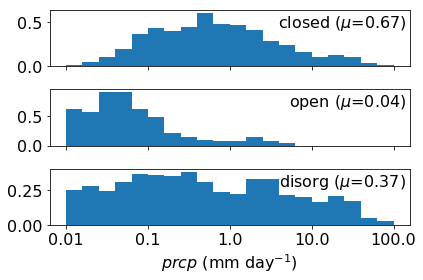

In [209]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,4))
# ticks = [10, 200, 100, 600]

for axi, scene in zip(ax, [1,0,3]):
    prcps = np.log10(np.concatenate(precip_by_scene[scene]))
#     axi.set_xticks(ticks)
#     axi.set_ylabel("#")
    axi.hist(np.array(prcps)[~np.isnan(prcps)], density=True, bins=np.linspace(-2, 2, 21))#bins = np.logspace(np.log10(0.01), np.log10(30), 21), log=True)
    axi.annotate('{} ($\mu$={:0.2f})'.format(str(scene_dict[scene]), 10**np.nanmean(prcps)), xy=(0.99, 0.95), xycoords='axes fraction', 
                 verticalalignment='top', horizontalalignment='right', fontsize=16)
ax[2].set_xlabel(r"$prcp$ (mm day$^{-1}$)")
# ax[2].set_xticks([np.linspace(-1, 2, 6)])
ax[2].set_xticklabels([10**i for i in ax[2].get_xticks()])
# plt.suptitle(r"Accum concentration", y=1.1)
# ax[2].set_xscale('log')
# ax[2].set_xticks(ticks)
# ax[2].set_xticklabels(ticks)

fig.tight_layout()

fig.savefig("/home/disk/user_www/jkcm/misc/agu/precip_pdf.png", dpi=600, bbox_inches='tight')


In [191]:
for axi, scene in zip(ax, [1,0,3]):
    prcps = np.concatenate(precip_by_scene[scene])
    light_drizzles = np.logical_and(prcps>0.1, prcps<2)
    heavy_drizzles = precips>2
    
    print('light drizzle frac: {:%}'.format(sum(light_drizzles)/sum(~np.isnan(prcps))))
    print('heavy drizzle frac: {:%}'.format(sum(heavy_drizzles)/sum(~np.isnan(prcps))))

light drizzle frac: 60.715990%
heavy drizzle frac: 0.000000%
light drizzle frac: 17.175573%
heavy drizzle frac: 0.000000%
light drizzle frac: 37.646722%
heavy drizzle frac: 0.000000%


In [31]:
radarlidar_file = r'/home/disk/eos10/imccoy/CSET_RadarLidarData/RF07_COMBINED_HCR_HSRL_data_mask_version4.cdf'
data = xr.open_dataset(radarlidar_file)

In [32]:
data

<xarray.Dataset>
Dimensions:                (layer_no: 20, range: 699, time: 54745)
Coordinates:
  * range                  (range) float64 40.0 60.0 80.0 100.0 120.0 140.0 ...
Dimensions without coordinates: layer_no, time
Data variables:
    absolute_time          (time) timedelta64[ns] ...
    lat                    (time) float32 ...
    lon                    (time) float32 ...
    alt_msl                (time) float32 ...
    ant_elev_angle         (time) float32 ...
    ant_az_angle           (time) float32 ...
    beta                   (time, range) float32 ...
    beta_molecular         (time, range) float32 ...
    beta_std               (time, range) float32 ...
    ratio_bscat            (time, range) float32 ...
    dBZ                    (time, range) float32 ...
    vel                    (time, range) float32 ...
    sp_width               (time, range) float32 ...
    SNR_HCR                (time, range) float32 ...
    combined_mask          (time, range) float32 ...

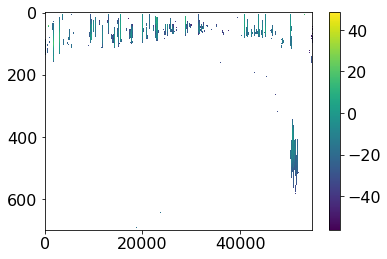

In [33]:
dbz = data.dBZ.T.values
dbz[dbz<-2000] = np.nan

# data.dBZ.where(data.dBZ<-2000) = np.nan
plt.imshow(dbz, aspect='auto')
plt.colorbar()

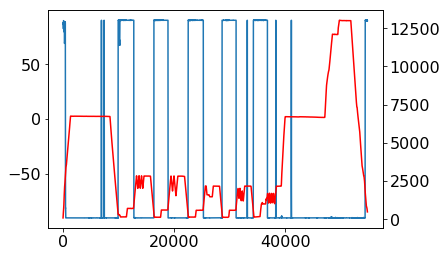

In [34]:
plt.plot(data.ant_elev_angle)
ax2 = plt.twinx()
ax2.plot(data.alt_msl,'r')